# TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
from torch import optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

In [3]:
# Load Data
data_transforms = {
    "train" : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = "data/hymenoptera_data/"

image_datasets = {x:datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ["train", "val"]}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

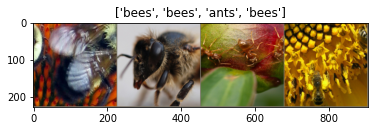

In [8]:
# Visualize a few images

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders["train"]))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [13]:
# Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [14]:
# Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
# Finetuning the convnet

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [16]:
#train and eval

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7190 Acc: 0.6393
val Loss: 0.2522 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.6284 Acc: 0.7377
val Loss: 0.1795 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.5179 Acc: 0.7992
val Loss: 0.3120 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.5049 Acc: 0.7664
val Loss: 0.2769 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.6084 Acc: 0.7664
val Loss: 0.2379 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.5023 Acc: 0.8197
val Loss: 0.7251 Acc: 0.8039

Epoch 6/24
----------
train Loss: 0.5833 Acc: 0.7992
val Loss: 0.7386 Acc: 0.7516

Epoch 7/24
----------
train Loss: 0.6085 Acc: 0.8156
val Loss: 0.3282 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.3081 Acc: 0.8402
val Loss: 0.3009 Acc: 0.8889

Epoch 9/24
----------
train Loss: 0.2651 Acc: 0.8730
val Loss: 0.2353 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2841 Acc: 0.8648
val Loss: 0.2552 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.3204 Acc: 0.8566
val Loss: 0.2396 Acc: 0.9281

Ep

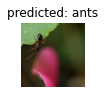

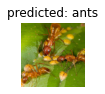

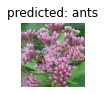

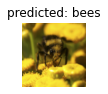

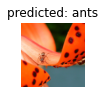

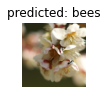

In [17]:
visualize_model(model_ft)

In [18]:
# ConvNet as Fixed feature Extractor

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

c:\Users\SB15\miniconda3\envs\aiWs\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\SB15\miniconda3\envs\aiWs\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6345 Acc: 0.6803
val Loss: 0.3076 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.5599 Acc: 0.7418
val Loss: 0.2348 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.5244 Acc: 0.7992
val Loss: 0.2785 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.4356 Acc: 0.8156
val Loss: 0.2563 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.5815 Acc: 0.7418
val Loss: 0.3775 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.4286 Acc: 0.8402
val Loss: 0.1794 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4110 Acc: 0.8238
val Loss: 0.2360 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.3652 Acc: 0.8320
val Loss: 0.1859 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.2470 Acc: 0.8770
val Loss: 0.1698 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.2700 Acc: 0.8934
val Loss: 0.1754 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3665 Acc: 0.8320
val Loss: 0.1994 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3342 Acc: 0.8689
val Loss: 0.2056 Acc: 0.9281

Ep

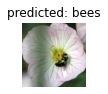

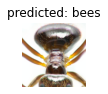

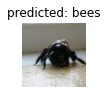

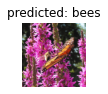

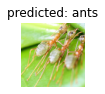

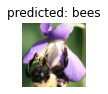

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()